# Heat equation 1D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

## Libraries

In [3]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/kinetick/kinetick/source')
sys.path.append('/home/juanfelipe/Desktop/research/kinetick/source')

In [4]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from integrate import trap
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Utils

In [5]:
def Kphiphi_assembly(Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary
  
  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val1 = K(kernel, Xomega, Xomega, k_param)
  val2 = K_ddot(kernel, Xomega, Xomega, k_param, 0, 0)
  val3 = K_ddot(kernel, Xomega, Xomega, k_param, 1, 1)
  #val3 = val2
  val4 = K_ddddot(kernel, Xomega, Xomega, k_param, 0, 0, 1, 1)
  val = val1 - h*val2 - h*(val3 - h*val4)
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val1 = K(kernel, Xomega, Xboundary, k_param)
  val2 = K_ddot(kernel, Xomega, Xboundary, k_param, 0, 0)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = K(kernel, Xboundary , Xboundary, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [6]:
def Kphi_assembly(Xtest, Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val1 = K(kernel, Xomega, Xtest, k_param)
  val2 = K_ddot(kernel, Xomega, Xtest, k_param, 0, 0)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = K(kernel, Xboundary , Xtest, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

## How far can we go ?

In [7]:
# X_full
Xfull = np.linspace(0,1,52)
# X_{\partial\Omega}
Xboundary = Xfull[[0,-1]]
# X_\Omega
Xomega = Xfull[1:-1]
# u(X_\Omega,0)
u0 = heat_u0(Xomega)
# Time step
h = 0.01

Build `Kphiphi`

In [8]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = 0.5)

Build `y_prev`

In [9]:
y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

Compute $K(\varphi,\varphi)^{-1}y_{\text{prev}}$

In [10]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + 1e-10*R,y_prev)

Get `K(Xtest,Xfull)`

In [11]:
Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

In [12]:
u_next = np.dot(Kphi.T,sol)

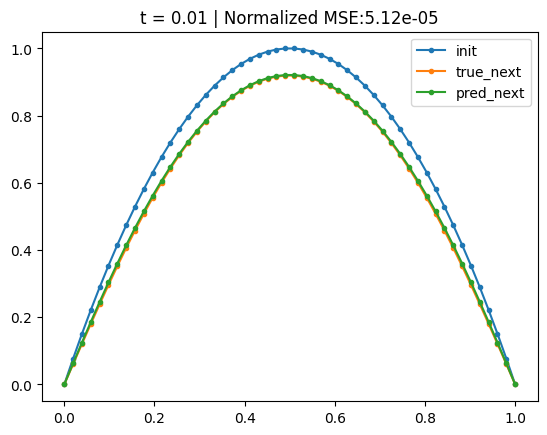

In [13]:
# Initial condition with Numerical vs. Analytical
plt.plot(Xfull,heat_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,heat_sol(Xfull,h,5),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,heat_sol(Xfull,h,5))/mean_squared_error(0*heat_sol(Xfull,h,5),heat_sol(Xfull,h,5))
plt.title('t = {} | Normalized MSE:{}'.format(h, round(nmse,7)))
plt.legend()
plt.show()

## Let's take small steps 

Say we want to get to `t=0.2` by taking `h = 0.01`

In [14]:
t = 0.2
steps = int(t//h)
# Initialize at the initial condition
uprev = u0
for _ in range(steps):
    y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
    sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)
    u_next = np.dot(Kphi.T,sol)
    # update
    uprev = u_next[1:-1]

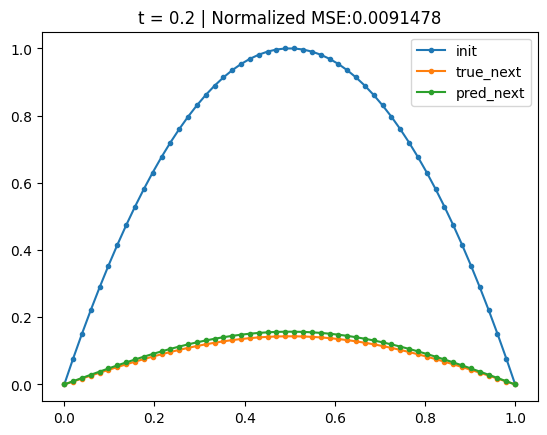

In [15]:
# Initial condition
plt.plot(Xfull,heat_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,heat_sol(Xfull,t,5),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,heat_sol(Xfull,t,5))/mean_squared_error(0*heat_sol(Xfull,t,5),heat_sol(Xfull,t,5))
plt.title('t = {} | Normalized MSE:{}'.format(t, round(nmse,7)))
plt.legend()
plt.show()

## Convergence

In [17]:
nugget = 1e-9

### Experiment 1

- $h = $ `1e-1`
- $t = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [18]:
# Experiment 1.1 - L2-norms
L2_norms_1 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-1
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_1.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.08336311682235502
0.08348852452009783
0.08347255837618595
0.08347212648724747
0.0834720951663481
0.0834720899857715
0.0834720876191858
0.08347208550613266


- $h = $ `1e-2`
- $t = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [19]:
# Experiment 1.2 - L2-norms
L2_norms_2 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-2
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_2.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.00945287406269737
0.009718727767394719
0.00970776596453355
0.009706556649503196
0.009706374993688713
0.009706324455210755
0.009706297914657073
0.009706274263846468


- $h = $ `1e-3`
- $t = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [20]:
# Experiment 1.3 - L2-norms
L2_norms_3 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-3
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_3.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.000737042082238939
0.0010119588121065494
0.0009879782201958054
0.0009856960518249368
0.0009849691480256803
0.000984145387263669
0.0009828660836143312
0.0009810220421711563


- $h = $ `1e-4`
- $t = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [21]:
# Experiment 1.4 - L2-norms
L2_norms_4 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-4
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_4.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.0001716483264180725
0.00013226328896585553
0.00010466741320164718
9.943958712125474e-05
9.82043494679365e-05
9.761534691049106e-05
9.698749720824806e-05
9.598673351267733e-05


- $h = $ `1e-5`
- $t = 0.2$
- Collocation points increasing from $2^2$ to $2^{10}$

In [22]:
# Experiment 1.5 - L2-norms
L2_norms_5 = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-5
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_5.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.00024959919191578934
4.57859819229384e-05
2.619777901231709e-05
2.113841580239551e-05
1.989346689089461e-05
1.9485026571789237e-05
1.9188260274810507e-05
1.8855378376971057e-05


Text(0.5, 1.0, '$h = 1e-5$')

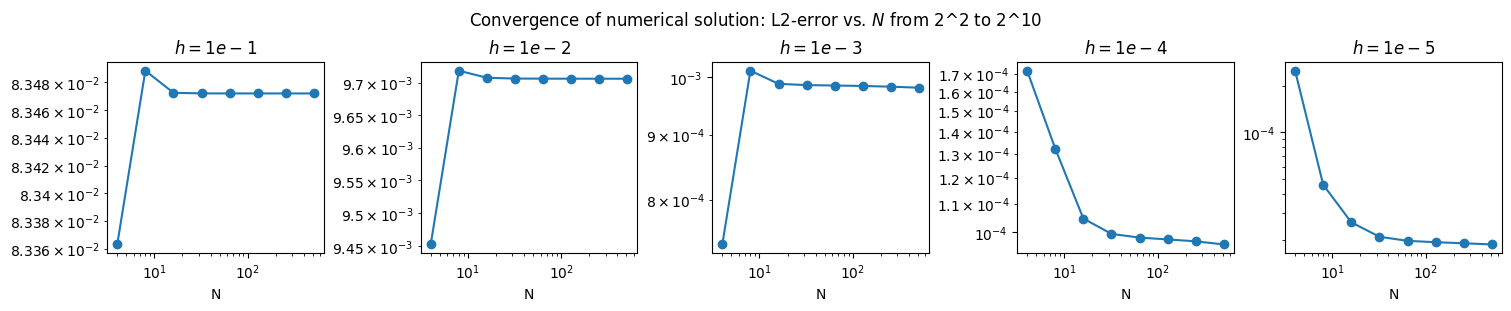

In [23]:
# Different plots
fig, axs = plt.subplots(nrows = 1, ncols=5 , figsize = (15,3),constrained_layout=True)
fig.suptitle('Convergence of numerical solution: L2-error vs. $N$ from 2^2 to 2^10')
axs[0].loglog(xrange, L2_norms_1, marker = 'o')
axs[0].set_xlabel('N')
axs[0].set_title('$h = 1e-1$')
axs[1].loglog(xrange, L2_norms_2, marker = 'o')
axs[1].set_xlabel('N')
axs[1].set_title('$h = 1e-2$')
axs[2].loglog(xrange, L2_norms_3, marker = 'o')
axs[2].set_xlabel('N')
axs[2].set_title('$h = 1e-3$')
axs[3].loglog(xrange, L2_norms_4, marker = 'o')
axs[3].set_xlabel('N')
axs[3].set_title('$h = 1e-4$')
axs[4].loglog(xrange, L2_norms_5, marker = 'o')
axs[4].set_xlabel('N')
axs[4].set_title('$h = 1e-5$')

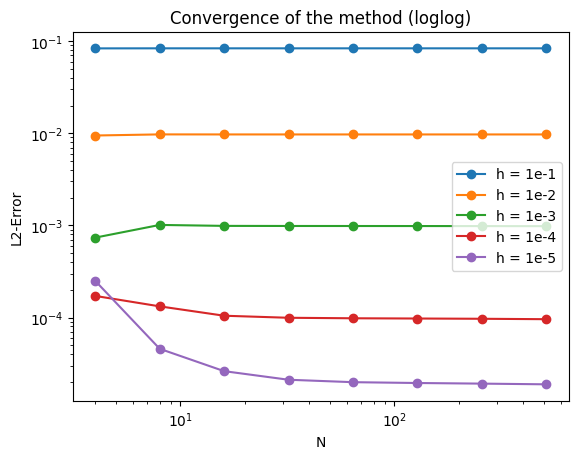

In [24]:
# One plot
plt.loglog(xrange,L2_norms_1,label = 'h = 1e-1', marker = 'o')
plt.loglog(xrange,L2_norms_2,label = 'h = 1e-2', marker = 'o')
plt.loglog(xrange,L2_norms_3,label = 'h = 1e-3', marker = 'o')
plt.loglog(xrange,L2_norms_4,label = 'h = 1e-4', marker = 'o')
plt.loglog(xrange,L2_norms_5,label = 'h = 1e-5', marker = 'o')
plt.xlabel('N')
plt.ylabel('L2-Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

### Experiment 2

- $h$ decreasing from `1e-2` to `1e-5`
- $t = 0.2$
- Collocation points = $2^5$

In [25]:
# Experiment 2.1 - L2-norms
L2_norms_1 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**5+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_1.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.009706556649503196
0.0009856960518249368
9.943958712125474e-05
2.113841580239551e-05


- $h$ decreasing from `1e-2` to `1e-5`
- $t = 0.2$
- Collocation points = $2^{6}$

In [26]:
# Experiment 2.2 - L2-norms
L2_norms_2 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**6+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_2.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.009706374993688713
0.0009849691480256803
9.82043494679365e-05
1.989346689089461e-05


- $h$ decreasing from `1e-2` to `1e-5`
- $t = 0.2$
- Collocation points = $2^{7}$

In [27]:
# Experiment 2.3 - L2-norms
L2_norms_3 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**7+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_3.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.009706324455210755
0.000984145387263669
9.761534691049106e-05
1.9485026571789237e-05


- $h$ decreasing from `1e-2` to `1e-5`
- $t = 0.2$
- Collocation points = $2^{8}$

In [28]:
# Experiment 2.4 - L2-norms
L2_norms_4 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**8+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_4.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.009706297914657073
0.0009828660836143312
9.698749720824806e-05
1.9188260274810507e-05


- $h$ decreasing from `1e-2` to `1e-5`
- $t = 0.2$
- Collocation points = $2^{9}$

In [29]:
# Experiment 2.5 - L2-norms
L2_norms_5 = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**9+2)
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = heat_u0(Xomega)
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.2
    # No. of steps
    steps = int(t//h)
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = 'Gaussian', k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Comput Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, k = 'Gaussian', k_param = 0.5)

    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]


    # u_true
    u_true = heat_sol(Xfull, t, 5)
    # Differences   
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms_5.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.009706274263846468
0.0009810220421711563
9.598673351267733e-05
1.8855378376971057e-05


Text(0.5, 1.0, '$N = 2^9$')

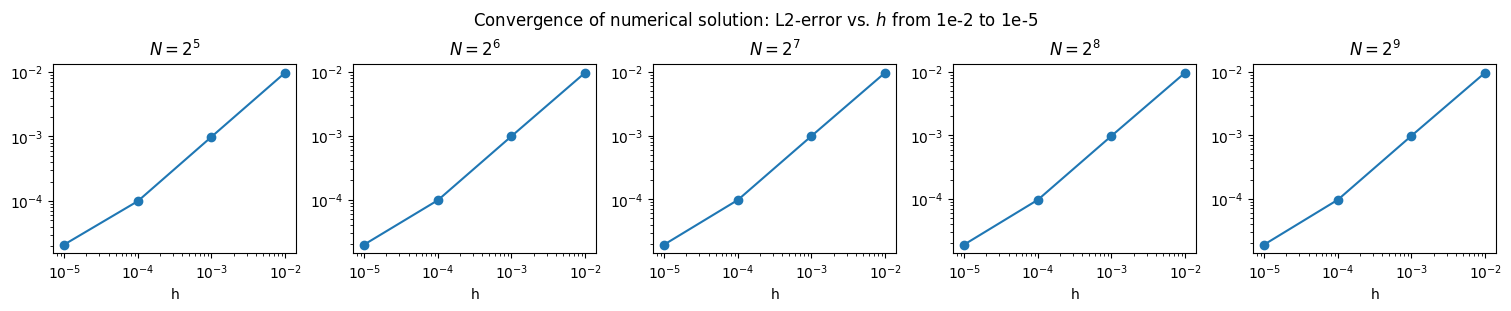

In [30]:
# Different plots
fig, axs = plt.subplots(nrows = 1, ncols=5 , figsize = (15,3),constrained_layout=True)
fig.suptitle('Convergence of numerical solution: L2-error vs. $h$ from 1e-2 to 1e-5')
axs[0].loglog(xrange, L2_norms_1, marker = 'o')
axs[0].set_xlabel('h')
axs[0].set_title('$N = 2^5$')
axs[1].loglog(xrange, L2_norms_2, marker = 'o')
axs[1].set_xlabel('h')
axs[1].set_title('$N = 2^6$')
axs[2].loglog(xrange, L2_norms_3, marker = 'o')
axs[2].set_xlabel('h')
axs[2].set_title('$N = 2^7$')
axs[3].loglog(xrange, L2_norms_4, marker = 'o')
axs[3].set_xlabel('h')
axs[3].set_title('$N = 2^8$')
axs[4].loglog(xrange, L2_norms_5, marker = 'o')
axs[4].set_xlabel('h')
axs[4].set_title('$N = 2^9$')

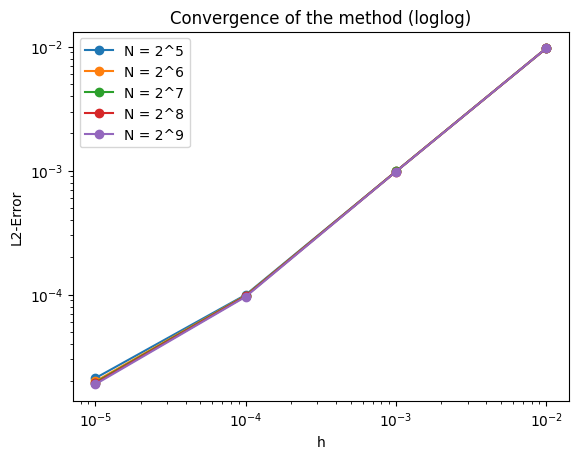

In [31]:
# One plot
plt.loglog(xrange,L2_norms_1,label = 'N = 2^5', marker = 'o')
plt.loglog(xrange,L2_norms_2,label = 'N = 2^6', marker = 'o')
plt.loglog(xrange,L2_norms_3,label = 'N = 2^7', marker = 'o')
plt.loglog(xrange,L2_norms_4,label = 'N = 2^8', marker = 'o')
plt.loglog(xrange,L2_norms_5,label = 'N = 2^9', marker = 'o')
plt.xlabel('h')
plt.ylabel('L2-Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()